In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
df = pd.read_csv("Sumner.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)


In [11]:
# inches → mm
df["ppt_mm"] = df["ppt (inches)"] * 25.4

# Fahrenheit → Celsius
df["tmean_C"] = (df["tmean (degrees F)"] - 32) * 5/9


In [12]:
def thornthwaite(tmean, lat, dates):
    tmean = tmean.clip(lower=0)

    I = (tmean / 5) ** 1.514
    I = I.groupby(dates.dt.year).transform("sum")

    a = (
        6.75e-7 * I**3
        - 7.71e-5 * I**2
        + 1.792e-2 * I
        + 0.49239
    )

    PET = 16 * (10 * tmean / I) ** a

    lat_rad = np.deg2rad(lat)
    month = dates.dt.month

    day_factor = np.array(
        [0.69, 0.72, 0.77, 0.83, 0.89, 0.93,
         0.95, 0.93, 0.89, 0.83, 0.77, 0.72]
    )

    PET = PET * day_factor[month - 1]
    return PET


In [13]:
latitude = 34.41
df["PET"] = thornthwaite(df["tmean_C"], latitude, df["Date"])


In [14]:
df["D"] = df["ppt_mm"] - df["PET"]


In [15]:
df["D_3"] = df["D"].rolling(3).sum()

df["SPEI_3"] = (
    (df["D_3"] - df["D_3"].mean()) /
    df["D_3"].std()
)


In [16]:
#Extracting sumer months only
df["month"] = df["Date"].dt.month
summer = df[df["month"].isin([6, 7, 8])].copy()


In [17]:
summer["year"] = summer["Date"].dt.year

near = summer[(summer["year"] >= 2020) & (summer["year"] < 2070)]
middle = summer[(summer["year"] >= 2070) & (summer["year"] < 2090)]
far = summer[(summer["year"] >= 2090) & (summer["year"] <= 2120)]


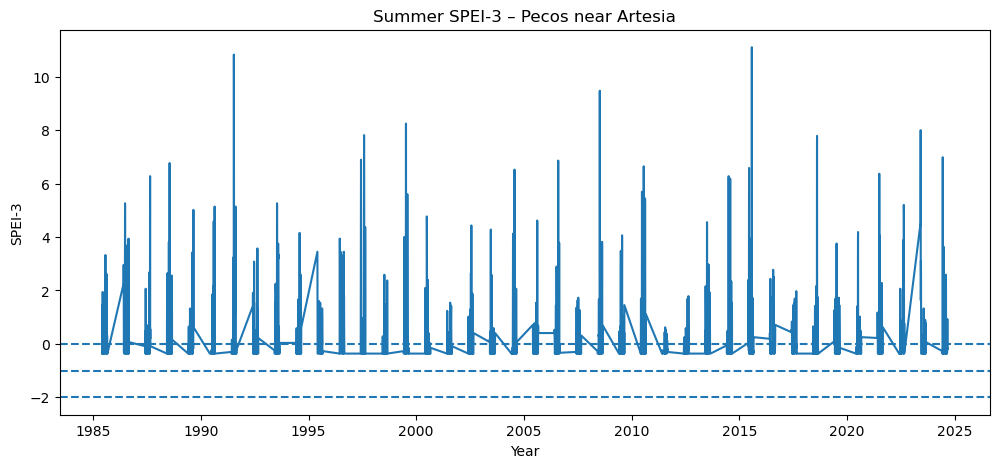

In [18]:
plt.figure(figsize=(12,5))
plt.plot(summer["Date"], summer["SPEI_3"])
plt.axhline(-1, linestyle="--")
plt.axhline(-2, linestyle="--")
plt.axhline(0, linestyle="--")
plt.title("Summer SPEI-3 – Pecos near Artesia")
plt.xlabel("Year")
plt.ylabel("SPEI-3")
plt.show()


In [19]:
df["Date"] = pd.to_datetime(df["Date"])


In [20]:
df.columns



Index(['Date', 'ppt (inches)', 'tmean (degrees F)', 'ppt_mm', 'tmean_C', 'PET',
       'D', 'D_3', 'SPEI_3', 'month'],
      dtype='object')

In [21]:
df["Date"] = pd.to_datetime(df["Date"])


In [22]:
df = df.set_index("Date")


In [23]:
df["Year"] = df.index.year
df["Month"] = df.index.month


In [24]:
print(type(df.index))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [25]:
df.head()

,ppt (inches),tmean (degrees F),ppt_mm,tmean_C,PET,D,D_3,SPEI_3,month,Year,Month
Date,,,,,,,,,,,
1985-01-01,0.00,32.7,0.000,0.388889,0.0,0.000,NaN,NaN,1,1985,1
1985-01-02,0.03,23.1,0.762,-4.944444,0.0,0.762,NaN,NaN,1,1985,1
1985-01-03,0.00,22.2,0.000,-5.444444,0.0,0.000,0.762,-0.273018,1,1985,1
1985-01-04,0.00,35.1,0.000,1.722222,0.0,0.000,0.762,-0.273018,1,1985,1
1985-01-05,0.00,40.1,0.000,4.500000,0.0,0.000,0.000,-0.365321,1,1985,1


In [26]:
summer = df[df["Month"].isin([6, 7, 8, 9])].copy()


In [27]:
historical_spei = summer["SPEI_3"].dropna().values


In [28]:
baseline_year = 2020
future_years = np.arange(2021, 2121)


In [29]:
trend_per_year = -0.01


In [30]:
np.random.seed(42)

future_spei = []


In [31]:
np.random.seed(42)

future_spei = []

for i, year in enumerate(future_years):
    sampled_value = np.random.choice(historical_spei)
    trend_shift = trend_per_year * i
    future_value = sampled_value + trend_shift
    future_spei.append([year, future_value])


In [32]:
for i in range(3):
    print(i)


0
1
2


In [33]:
future_df = pd.DataFrame(
    future_spei,
    columns=["Year", "SPEI"]
)


In [34]:
near = future_df[future_df["Year"] <= baseline_year + 50]

middle = future_df[
    (future_df["Year"] > baseline_year + 50) &
    (future_df["Year"] <= baseline_year + 70)
]

far = future_df[
    (future_df["Year"] > baseline_year + 70)
]


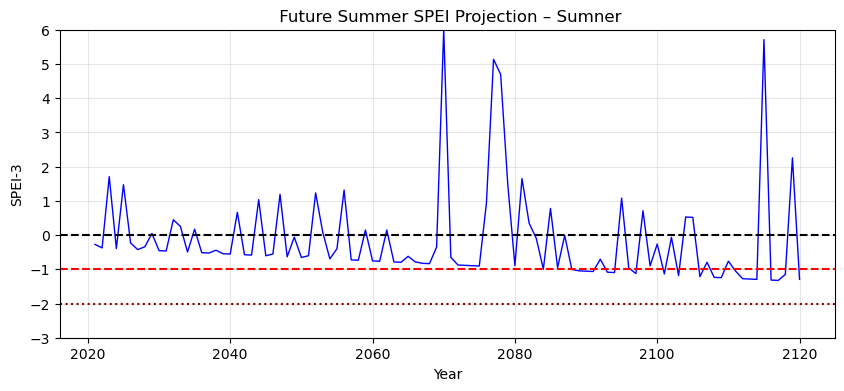

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(future_df["Year"], future_df["SPEI"], color="blue", linewidth=1)

# drought thresholds
plt.axhline(0, linestyle="--", color="black")
plt.axhline(-1, linestyle="--", color="red")
plt.axhline(-2, linestyle=":", color="darkred")

plt.xlabel("Year")
plt.ylabel("SPEI-3")
plt.title(" Future Summer SPEI Projection – Sumner")
plt.ylim(-3, 6)
plt.grid(alpha=0.3)
plt.show()
